In [1]:
import tqdm
import mlmi
import mlmi3
import numpy as np
import scipy.stats
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')

In [ ]:
cov = [[1,   0.5,   0],
       [0.5,   1,   0],
       [0,     0,   1]]
print(np.array(cov))
X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(3000)

In [ ]:
ami = np.zeros([3, 3])
for i, j in [(0, 1), (0, 2), (1, 2)]:
    ami[j, i] = ami[i, j] = mlmi.mutual_information(X[:, i].reshape(-1, 1), X[:, j].reshape(-1, 1), n_b=200)
    print('(%d, %d): %f' % (i, j, ami[i, j]))

In [ ]:
ami3 = mlmi3.mutual_information(X[:, 0].reshape(-1, 1), X[:, 1].reshape(-1, 1), X[:, 2:], n_b=200, maxiter=1000)
print('(0, 1, 2): %f' % ami3) # 0.95

In [ ]:
print('I(X, Y | Z) = %f' % (ami3 - ami[0, 2] - ami[1, 2]))
print('I(X, Z | Y) = %f' % (ami3 - ami[0, 1] - ami[2, 1]))
print('I(Y, Z | X) = %f' % (ami3 - ami[1, 0] - ami[2, 0]))

In [3]:
pre = [[1,   0.5,    0,    0],
       [0.5,   1,  0.4,    0],
       [0,   0.4,    1, -0.3],
       [0,     0, -0.3,    1]]
cov = np.linalg.inv(pre)
print(np.array(pre))
X = scipy.stats.multivariate_normal(mean=[0, 0, 0, 0], cov=cov).rvs(3000)

[[ 1.   0.5  0.   0. ]
 [ 0.5  1.   0.4  0. ]
 [ 0.   0.4  1.  -0.3]
 [ 0.   0.  -0.3  1. ]]


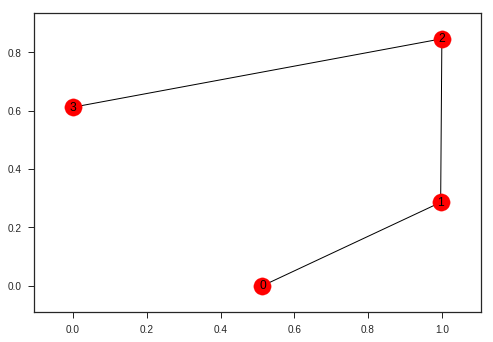

In [4]:
g = nx.from_numpy_matrix(np.array(pre))
nx.draw_networkx(g)

In [5]:
mi = np.zeros([4, 4])
cmi = np.zeros([4, 4])
for i, j in tqdm.tqdm([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]):
    mi[i, j] = mlmi.mutual_information(X[:, i].reshape(-1, 1), X[:, j].reshape(-1, 1), n_b=200, maxiter=1000)
    mask = (np.arange(4) != i) & (np.arange(4) != j)
    mi_xz = mlmi.mutual_information(X[:, i].reshape(-1, 1), X[:, mask], n_b=200, maxiter=1000)
    mi_yz = mlmi.mutual_information(X[:, j].reshape(-1, 1), X[:, mask], n_b=200, maxiter=1000)
    mi_xyz = mlmi3.mutual_information(X[:, i].reshape(-1, 1), X[:, j].reshape(-1, 1), X[:, mask], n_b=200, maxiter=1000)
    cmi[i, j] = mi_xyz - (mi_xz + mi_yz)

cmi

100%|██████████| 6/6 [05:39<00:00, 56.17s/it]


array([[ 0.        ,  0.12134803, -0.00941285, -0.00711464],
       [ 0.        ,  0.        ,  0.06664688, -0.00835197],
       [ 0.        ,  0.        ,  0.        ,  0.0431221 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

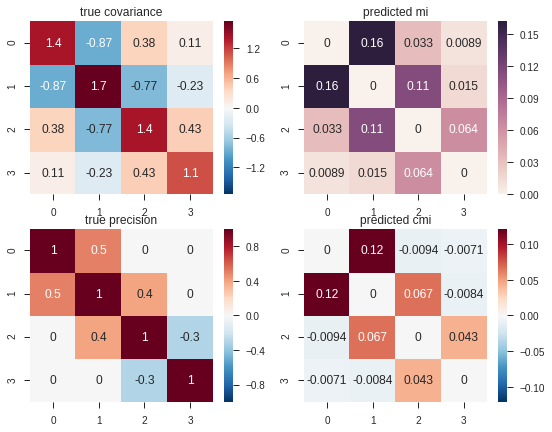

In [16]:
f, axes = plt.subplots(2, 2, figsize=[9, 7])
axes[0, 0].set_title('true covariance')
axes[0, 1].set_title('predicted mi')
axes[1, 0].set_title('true precision')
axes[1, 1].set_title('predicted cmi')
sns.heatmap(cov, annot=True, ax=axes[0, 0])
sns.heatmap(mi + np.transpose(mi), annot=True, ax=axes[0, 1])
sns.heatmap(pre, annot=True, ax=axes[1, 0])
sns.heatmap(cmi + np.transpose(cmi), annot=True, ax=axes[1, 1])
plt.savefig('cmi.png', dpi=600)